In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import plotly.express as px
import sklearn
from scipy.stats import randint
import os

pd.set_option('display.max_columns', None)
os.getcwd()

'c:\\Users\\parke\\data_work\\datascience\\machine_learning'

# Supermarket Classification 

## Import common Sklearn helper functions



In [6]:
# model selection, cross validation and hyperparam tuning
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# imputation
from sklearn.impute import SimpleImputer, KNNImputer

# pipelines
from sklearn.pipeline import make_pipeline

# custom transformers 
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# dummy model for baseline comparison
from sklearn.dummy import DummyClassifier

# classificaion model metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve , roc_auc_score, f1_score, roc_curve 



## Dataset Import and basic look

In [7]:
df = pd.read_csv('superstore_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Check for NA

In [8]:
df.isna().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

### Check for duplicates

In [11]:
df.duplicated().sum()

0

In [13]:
df.columns = df.columns.str.lower()
# dropping dt_customer (only date feature) for now but will come abck to it
df = df.drop(columns=['id','dt_customer'], axis = 1)
df.head(10)

,year_birth,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain
0,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,1958,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1967,Graduation,Together,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,1989,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0
5,1958,PhD,Single,71691.0,0,0,0,336,130,411,240,32,43,1,4,7,5,2,1,0
6,1954,2n Cycle,Married,63564.0,0,0,0,769,80,252,15,34,65,1,10,10,7,6,1,0
7,1967,Graduation,Together,44931.0,0,1,0,78,0,11,0,0,7,1,2,1,3,5,0,0
8,1954,PhD,Married,65324.0,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0
9,1954,PhD,Married,65324.0,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0


In [54]:
df.describe()

,year_birth,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107,0.009375
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274,0.096391
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000


In [55]:
px.histogram(df, 
    x = 'response',
    histnorm='probability density',
    height = 500,
    width = 600,
    title = 'Target Variable: response').show()

## Split Data

In [14]:

def splitter(df, target, train_size, random_state):
    # Returns versions of test and train with and without the target for simple processing throughout the notebook
    train, test = train_test_split(df, train_size= train_size, random_state = random_state)

    X_train = train.drop(target, axis = 1).copy()
    y_train = train[target].copy()

    X_test = test.drop(target, axis = 1).copy()
    y_test = test[target].copy()

    return(train, test, X_train, X_test, y_train, y_test)


In [15]:
train, test, X_train, X_test, y_train, y_test = splitter(df, target = 'response', train_size = .8, random_state = 324)


## EDA on Training Set

In [16]:
train.head()

,year_birth,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain
1356,1951,Graduation,Single,80872.0,0,0,60,483,72,567,94,12,108,1,4,4,10,1,0,0
629,1981,PhD,Married,87171.0,0,0,27,1001,44,107,58,44,44,1,6,7,11,2,0,0
402,1955,PhD,Together,75261.0,0,0,17,1239,17,413,23,34,17,1,5,6,5,2,1,0
1645,1965,Graduation,Married,44375.0,0,1,73,213,5,28,7,7,41,1,4,1,6,5,0,0
1801,1969,Master,Together,66476.0,0,1,80,742,28,152,25,9,57,2,6,8,10,4,0,0


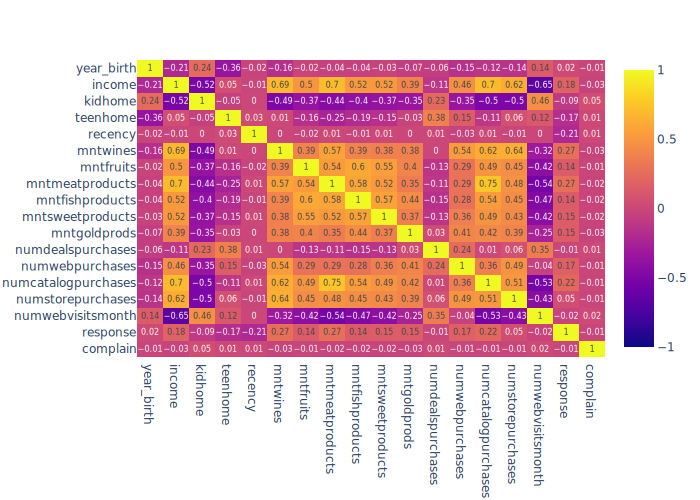

In [17]:
px.imshow(np.round(train.corr(),2),
    text_auto=True,
    aspect = 'auto',
    range_color = [-1,1]).show('svg')

In [18]:
np.abs(train.corrwith(df["response"])).sort_values(ascending = False)


response               1.000000
mntmeatproducts        0.266204
mntwines               0.265862
numcatalogpurchases    0.223129
recency                0.207873
income                 0.183426
teenhome               0.165504
numwebpurchases        0.165416
mntsweetproducts       0.145993
mntgoldprods           0.145578
mntfishproducts        0.137259
mntfruits              0.136711
kidhome                0.085923
numstorepurchases      0.050393
numwebvisitsmonth      0.016074
year_birth             0.015557
complain               0.009311
numdealspurchases      0.007227
dtype: float64

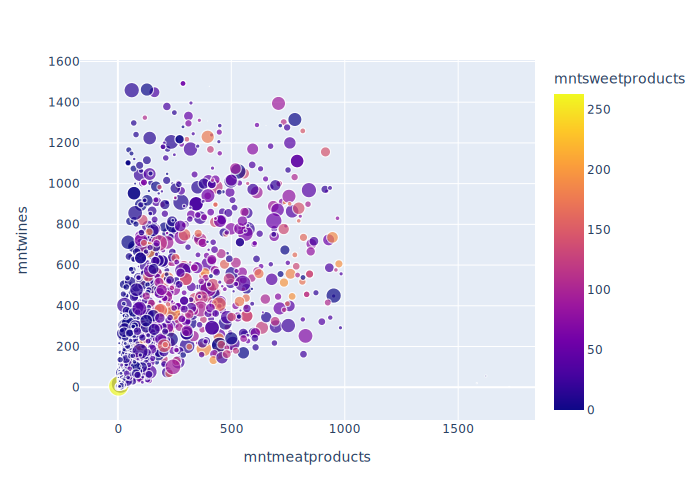

In [19]:
px.scatter(train,
    x = 'mntmeatproducts',
    y = 'mntwines',
    color = 'mntsweetproducts',
    size = 'mntgoldprods').show('svg')

### Exploring transformations for the highest correlated features to the target

In [20]:

# creates a list of the most highly correlated features to the target
cols_to_plot = np.abs(train.corrwith(df["response"])).sort_values(ascending = False).index[1:9].tolist()


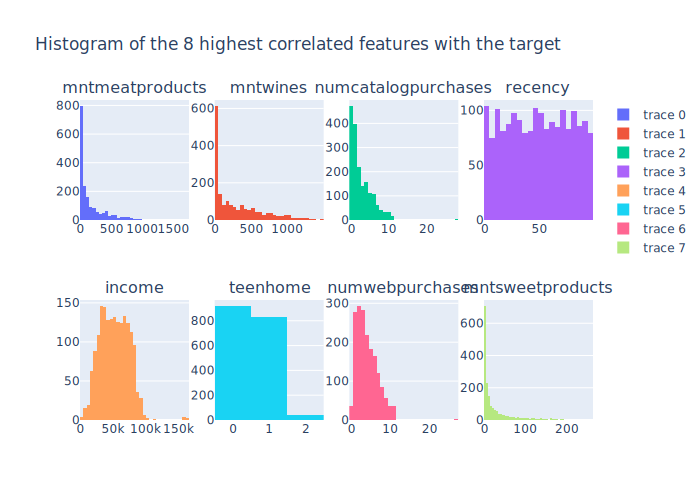

In [21]:

from plotly.subplots import make_subplots
import plotly.graph_objects as go


cols_to_plot = [('mntmeatproducts',1,1), 
    ('mntwines',1,2),
    ('numcatalogpurchases',1,3),
    ('recency',1,4),
    ('income',2,1), 
    ('teenhome',2,2), 
    ('numwebpurchases',2,3), 
    ('mntsweetproducts',2,4)]


fig  = make_subplots(rows = 2, 
    cols = 4,
    subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in cols_to_plot:
    hist = go.Histogram(x = train[i])
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histogram of the 8 highest correlated features with the target')
fig.show('svg')

- All the amount ('mnt') features appear to be strictly positive  and have right skew with moreate to heavy tails, log may be necessary
- income appears roughly normal - stand scalar prob fine
- recency looks roughly uniformly distributed  - stand scaler prob fine
- teen home looks pretty imbalanced - something to think about
- the number ('num') features are strictly positive but look confined to a somewhat narrow range minus some outliers - stand scaler may be fine for first pass

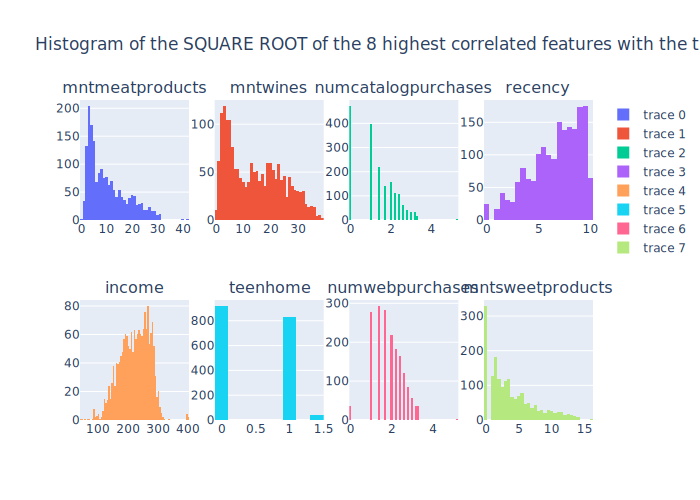

In [22]:
fig  = make_subplots(rows = 2, 
    cols = 4,
    subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in cols_to_plot:
    hist = go.Histogram(x = np.sqrt(train[i]))
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histogram of the SQUARE ROOT of the 8 highest correlated features with the target')
fig.show('svg')

- square root transformation does not appear to help any of the top features reach normality

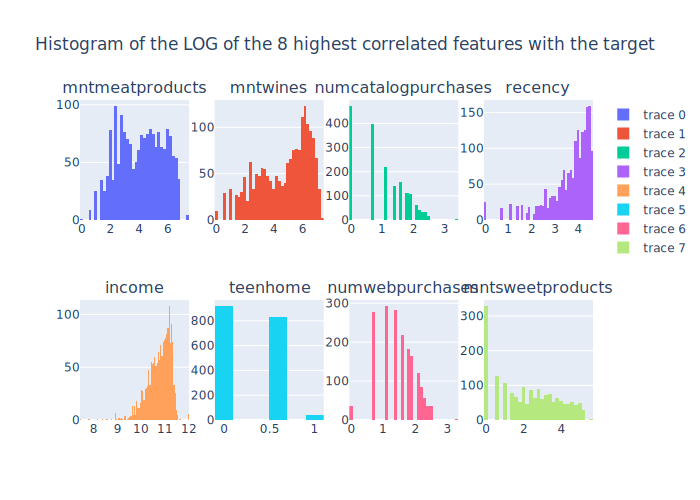

In [23]:
fig  = make_subplots(rows = 2, 
    cols = 4,
    subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in cols_to_plot:
    hist = go.Histogram(x = np.log1p(train[i]))
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histogram of the LOG of the 8 highest correlated features with the target')
fig.show('svg')

- log (1 + )transform appears to be reasonably appropriate for amount ('mnt) features

### How does the categorical data correlate with the respones?

In [24]:
train.groupby('education')['response'].mean()

education
2n Cycle      0.106918
Basic         0.048780
Graduation    0.139845
Master        0.151316
PhD           0.209302
Name: response, dtype: float64

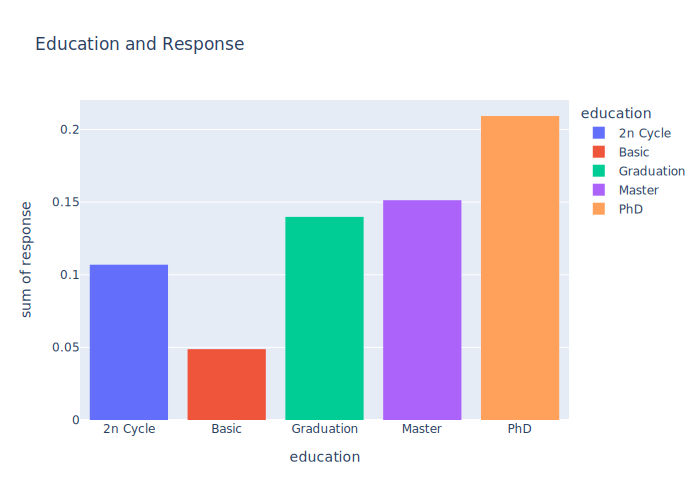

In [32]:
px.histogram(train.groupby('education').mean().reset_index(),
    x = 'education',
    y = 'response',
    color = 'education',
    title= 'Education and Response',
    labels= {'sum of response': "Response Rate by Group"}
    ).show('svg')

In [26]:
train['education'].value_counts()

Graduation    901
PhD           387
Master        304
2n Cycle      159
Basic          41
Name: education, dtype: int64

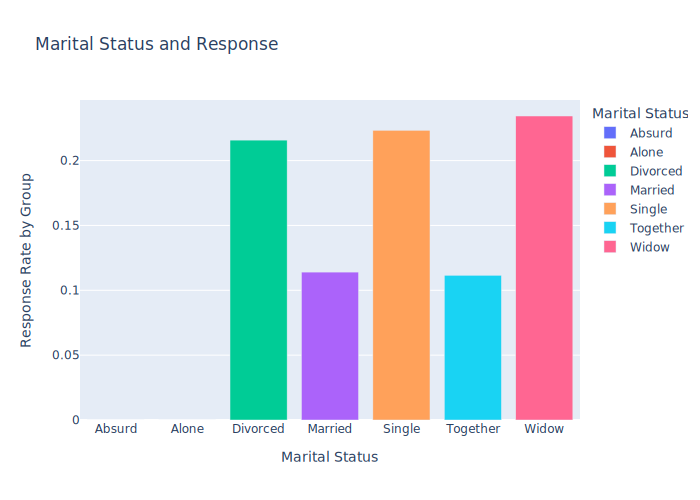

In [30]:
px.bar(train.groupby('marital_status').mean().reset_index(),
    x = 'marital_status',
    y = 'response',
    color = 'marital_status',
    title= 'Marital Status and Response',
    labels = {'response':"Response Rate by Group",
                "marital_status":"Marital Status"}
    ).show('svg')


In [28]:
train['marital_status'].value_counts()

# drop alone and absurd??

Married     684
Together    466
Single      385
Divorced    190
Widow        64
Alone         2
Absurd        1
Name: marital_status, dtype: int64

## Trying out a few different estimators

### Baseline Dummy Model
- imputes missing income data but otherwise does 0 preprocessing

In [33]:
cat_features = ['education','marital_status']
num_features = X_train.select_dtypes(include=[np.number]).columns

In [34]:
cat_processor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor = make_pipeline(
    SimpleImputer(strategy = 'median')
)

preprocessing = make_column_transformer(
    (cat_processor, cat_features),
    (num_processor, num_features)

)

baseline = make_pipeline(preprocessing, DummyClassifier())
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_train)

print('Baseline Accuracy score:')
print(baseline.score(X_train, y_train))
print('-----------')
print("Baseline confusion matrix:")
print(confusion_matrix(y_train, base_pred))
print('-----------')
print("Baseline model 5 fold Cross Val Accuracy scores")
print(cross_val_score(baseline, X_train, y_train, cv = 5, scoring = 'accuracy'))

Baseline Accuracy score:
0.8482142857142857
-----------
Baseline confusion matrix:
[[1520    0]
 [ 272    0]]
-----------
Baseline model 5 fold Cross Val Accuracy scores
[0.84679666 0.84679666 0.84916201 0.84916201 0.84916201]


### Preprocessing for candidate models

In [35]:
cat_processor = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

log_processor = make_pipeline(
    SimpleImputer(strategy = 'median'),
    FunctionTransformer(np.log1p),
    StandardScaler()
)

default_num_processor = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler()
)

### SGD Linear SVM

In [37]:
log_features = train.columns[train.columns.str.startswith('mnt') == True].to_list()

preprocessing_plus = ColumnTransformer(
    [
    ('cat', cat_processor, make_column_selector(dtype_include = 'object')),
    ('log', log_processor, log_features)
    ], remainder= default_num_processor)

from sklearn.linear_model import SGDClassifier

linearsvm = make_pipeline(preprocessing, SGDClassifier(loss = 'hinge'))     # 'hinge' means linear SVM 
linearsvm.fit(X_train, y_train)
linearsvm_pred = linearsvm.predict(X_train)

print('linearsvm Accuracy score:')
print(linearsvm.score(X_train, y_train))
print('-----------')
print("linearsvm confusion matrix:")
print(confusion_matrix(y_train, linearsvm_pred))
print('-----------')
print("linearsvm model 5 fold Cross Val Accuracy scores")
print(cross_val_score(linearsvm, X_train, y_train, cv = 5, scoring = 'accuracy'))


linearsvm Accuracy score:
0.84765625
-----------
linearsvm confusion matrix:
[[1519    1]
 [ 272    0]]
-----------
linearsvm model 5 fold Cross Val Accuracy scores
[0.74651811 0.84401114 0.77374302 0.81005587 0.85195531]


### Polynomial Kernel SVM

In [38]:
from sklearn.svm import SVC

kernelsvm = make_pipeline(preprocessing_plus, SVC(kernel = 'poly', degree = 3, coef0 = 1, C = 5))
kernelsvm.fit(X_train, y_train)
kernelsvm_pred = kernelsvm.predict(X_train)

print('kernelsvm Accuracy score:')
print(kernelsvm.score(X_train, y_train))
print('-----------')
print("kernelsvm confusion matrix:")
print(confusion_matrix(y_train, kernelsvm_pred))
print('-----------')
print("kernelsvm model 5 fold Cross Val Accuracy scores")
print(cross_val_score(kernelsvm, X_train, y_train, cv = 5, scoring = 'accuracy'))


kernelsvm Accuracy score:
0.9665178571428571
-----------
kernelsvm confusion matrix:
[[1506   14]
 [  46  226]]
-----------
kernelsvm model 5 fold Cross Val Accuracy scores
[0.84401114 0.84122563 0.84916201 0.83798883 0.8603352 ]


### Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfclassifier = make_pipeline(preprocessing_plus, RandomForestClassifier())
rfclassifier.fit(X_train, y_train)
rfclassifier_pred = rfclassifier.predict(X_train)

print('rfclassifier Accuracy score:')
print(rfclassifier.score(X_train, y_train))
print('-----------')
print("rfclassifier confusion matrix:")
print(confusion_matrix(y_train, rfclassifier_pred))
print('-----------')
print("rfclassifier model 5 fold Cross Val Accuracy scores")
print(cross_val_score(rfclassifier, X_train, y_train, cv = 5, scoring = 'accuracy'))


rfclassifier Accuracy score:
0.9944196428571429
-----------
rfclassifier confusion matrix:
[[1520    0]
 [  10  262]]
-----------
rfclassifier model 5 fold Cross Val Accuracy scores
[0.85793872 0.86629526 0.87150838 0.86871508 0.86871508]


In [40]:
cross_val_score(rfclassifier, X_train, y_train, cv = 5, scoring = 'accuracy')

array([0.84958217, 0.86629526, 0.87150838, 0.86871508, 0.87430168])

In [41]:
rfcl_param_distribs = {'randomforestclassifier__n_estimators':randint(50,250),
                        'randomforestclassifier__min_samples_split': randint(2,10),
                        'randomforestclassifier__min_samples_leaf':randint(1,10)}

rnd_search = RandomizedSearchCV(
    rfclassifier, 
    param_distributions = rfcl_param_distribs, 
    n_iter = 10, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
rnd_search.best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 169}

In [42]:
rfcl_param_distribs = {'randomforestclassifier__n_estimators':randint(150,190),
                        'randomforestclassifier__min_samples_split': randint(2,5),
                        'randomforestclassifier__min_samples_leaf':randint(1,3)}

rnd_search = RandomizedSearchCV(
    rfclassifier, 
    param_distributions = rfcl_param_distribs, 
    n_iter = 10, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
rnd_search.best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 167}

In [43]:
rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.525046,0.023732,0.035834,0.002202,1,3,167,{'randomforestclassifier__min_samples_leaf': 1...,0.855153,0.869081,0.868715,0.877095,0.885475,0.871104,0.010066,1
8,0.680916,0.156614,0.059244,0.037674,1,4,171,{'randomforestclassifier__min_samples_leaf': 1...,0.852368,0.869081,0.868715,0.877095,0.885475,0.870547,0.010970,2
2,1.064406,0.448421,0.055023,0.019525,1,2,185,{'randomforestclassifier__min_samples_leaf': 1...,0.855153,0.869081,0.874302,0.874302,0.879888,0.870545,0.008421,3
6,0.631843,0.038418,0.054503,0.024719,1,3,158,{'randomforestclassifier__min_samples_leaf': 1...,0.857939,0.866295,0.874302,0.877095,0.877095,0.870545,0.007442,3
4,0.606571,0.100874,0.043472,0.010230,2,4,170,{'randomforestclassifier__min_samples_leaf': 2...,0.855153,0.860724,0.877095,0.877095,0.877095,0.869432,0.009549,5


In [44]:
final_rfc = rnd_search.best_estimator_

## Comparing performance across the estimators

### Define a function to grab most relevant stas of each estimator using cross validation

In [45]:
def classification_cv_metrics(model, X_train, y_train, cv, method, model_name):
    # model is the same thing as estimator
    # method will likely either be 'decision_function' or 'predict_proba' depending on the estimator
    # model_name is how the model will appear in downstream datasets of performance scores across all models

    # Obtain cross validation scores
    y_scores = cross_val_predict(estimator = model, X = X_train, y = y_train, cv = cv, method = method)

    # Depending on the estimator the scores output may be mutlidimensional, for example random forest predict_proba returns 2 probabilities for each instance
    if y_scores.ndim > 1:
        y_scores_mod = y_scores[:,1]
    else:
        y_scores_mod = y_scores

    # create a dataframe for precision and recall 
    precision, recall, threshold = precision_recall_curve(y_train, y_scores_mod)
    pr_data = {'model':model_name, 'precision':precision[:-1], 'recall':recall[:-1], 'threshold':threshold}
    pr_wide = pd.DataFrame(pr_data)
    pr_long = pr_wide.melt(id_vars = ['threshold','model'])

    # create dataframes for ROC curve TPR (recall, sensitivity) and FPR (Fallout, 1 - specificity)
    fpr, tpr, threshold = roc_curve(y_train, y_scores_mod)
    roc_data = {'model':model_name,'fpr':fpr,'tpr':tpr,'threshold':threshold}
    roc_wide = pd.DataFrame(roc_data)
    roc_long = roc_wide.melt(id_vars = ['threshold','model'])

    return(pr_wide, pr_long, roc_wide, roc_long)


### Run all the models through the cross val function defined above

In [46]:
base_prw, base_prl, base_rocw, base_rocl = classification_cv_metrics(model=baseline, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'base')

In [47]:
lsvm_prw, lsvm_prl, lsvm_rocw, lsvm_rocl = classification_cv_metrics(model=linearsvm, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'decision_function',
    model_name = 'lsvm')

In [48]:
ksvm_prw, ksvm_prl, ksvm_rocw, ksvm_rocl = classification_cv_metrics(model=kernelsvm, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'decision_function',
    model_name = 'ksvm')

In [49]:
rfcl_prw, rfcl_prl, rfcl_rocw, rfcl_rocl = classification_cv_metrics(model=rfclassifier, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'rfcl')

In [50]:
final_rfc_prw, final_rfc_prl, final_rfc_rocw, final_rfc_rocl = classification_cv_metrics(model=final_rfc, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'final_rfc')

### Combine al lthe results

In [51]:

# Generate wide datasets of all models' precision and recall scores
models_prw = pd.concat([base_prw,lsvm_prw, ksvm_prw, rfcl_prw, final_rfc_prw])
models_prl = pd.concat([base_prl,lsvm_prl, ksvm_prl, rfcl_prl, final_rfc_prl])

# generate long datasets of all models' reciever operator characteristics
models_rocw = pd.concat([base_rocw,lsvm_rocw, ksvm_rocw, rfcl_rocw, final_rfc_rocw])
models_rocl = pd.concat([base_rocl,lsvm_rocl, ksvm_rocl, rfcl_rocl, final_rfc_rocl])


### Plots of performance across models

Precision and Recall by threshold faceted by model

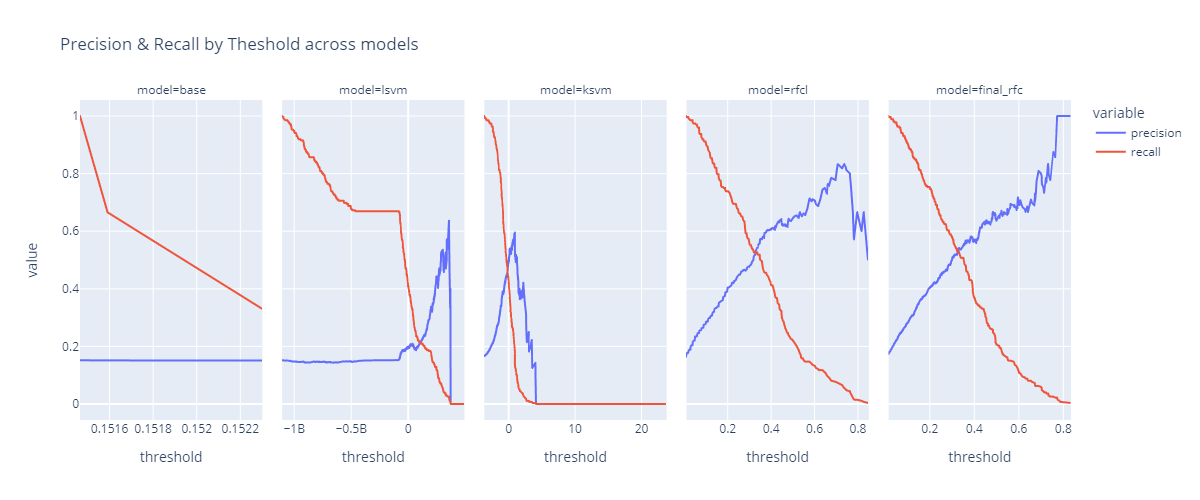

In [58]:
fig = px.line(models_prl, 
    x = 'threshold', 
    y = 'value', 
    color = 'variable',
    facet_col = 'model',
    title = 'Precision & Recall by Theshold across models',
    width = 1200)
    
fig.update_xaxes(matches = None)
fig.show('png')

Precision vs. recall curves for all models

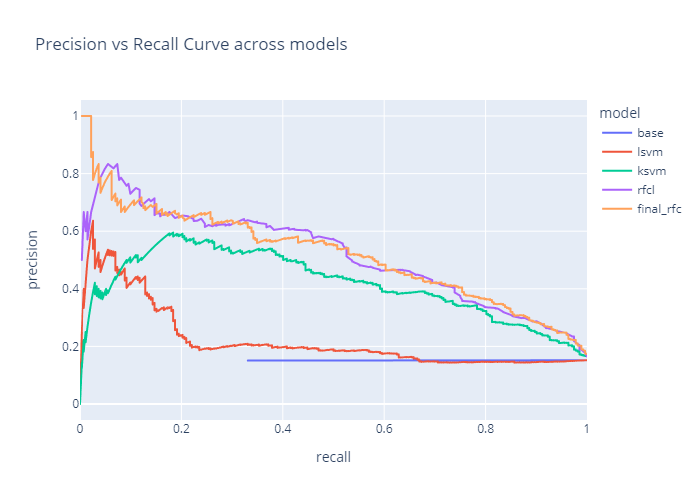

In [56]:
px.line(models_prw, 
    x = 'recall',
    y = 'precision',
    color = 'model',
    title = 'Precision vs Recall Curve across models').show('png')

ROC curves for all models

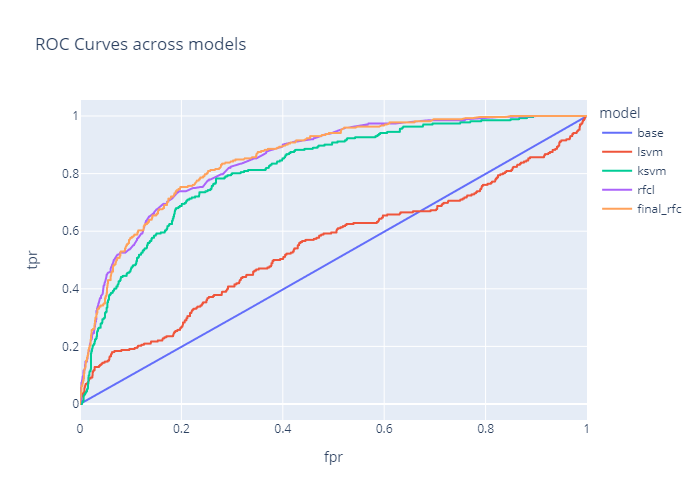

In [57]:
px.line(models_rocw,
    x = 'fpr',
    y = 'tpr',
    color = 'model',
    title = 'ROC Curves across models').show('png')

## Inspection of model errors 
- Does the model perform equally well across categories?
- Are there systematic ways in which the model makes errors?